### Lab: Navigating the Lunar Lander with a Dueling Deep Q Network

### University of Virginia
### Reinforcement Learning
#### Last updated: February 27, 2024

Jack Burke
jpb2uj
---

#### Instructions:

You will work with the `LunarLander-v2` environment from `gymnasium` in this lab.  

An overview of the environment can be found [here](https://gymnasium.farama.org/).  
If you're curious about the source code, see [here](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/box2d/lunar_lander.py).

Your mission will be to implement a dueling deep Q -network using PyTorch.  
You might run this on Colab.

There are a few specific tasks outlined below for you to solve.

The bigger tasks will be to:

- Show that the algorithm works to train the agent in the environment
- Run episodes and show the results

**Submission**  
As you will likely have several files including this notebook, you can zip all files and submit.

---

![lunar](https://github.com/jackburke12/applied_reinforcement_learning/blob/main/07_deep_q_networks_extensions2/lunar_lander1.png?raw=1)

#### TOTAL POINTS: 12

---

**Hint:** Modules you may need to install include:

swig  
gym[box2d]  
gymnasium

#### 1) What is the penalty for crashing?  
**(POINTS: 1)**


-100 is the penalty for crashing.

#### 2) Set up the environment and run 2 steps by taking random actions.
**(POINTS: 1)**

In [1]:
pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.8 MB/s eta 0:00:00


In [2]:
pip install "gymnasium[box2d]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2399000 sha256=1f069f07594630e01c535896a4780f37f3497d34d16b32eeb829df3a65cc40d8
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [3]:
import gymnasium as gym

env = gym.make("LunarLander-v3", render_mode="human")
obs, info = env.reset()
print("Initial Observation: ", obs)

for step in range(2):
    action = env.action_space.sample()
    next_obs, reward, terminated, truncated, info = env.step(action)
    print(f"Step {step+1}")
    print("Action:", action)
    print("Next obs:", next_obs)
    print("Reward:", reward, "Terminated:", terminated, "Truncated:", truncated)

Initial Observation:  [ 9.0789792e-05  1.4052429e+00  9.1710594e-03 -2.5231609e-01
 -9.8312688e-05 -2.0773860e-03  0.0000000e+00  0.0000000e+00]
Step 1
Action: 2
Next obs: [ 1.7929077e-04  1.4002695e+00  8.9609753e-03 -2.2104497e-01
 -2.1142210e-04 -2.2616056e-03  0.0000000e+00  0.0000000e+00]
Reward: 3.3116522132034563 Terminated: False Truncated: False
Step 2
Action: 1
Next obs: [ 1.8930435e-04  1.3946996e+00 -8.7541871e-04 -2.4754979e-01
  1.6483872e-03  3.7199669e-02  0.0000000e+00  0.0000000e+00]
Reward: -2.249193286087659 Terminated: False Truncated: False


#### 3) Briefly discuss your approach to solving the problem  
**(POINTS: 2)**



The environment provides an 8-dimensional continuous state vector and 4 discrete actions: do nothing, fire left, fire main, and fire right. We'll create a dueling deep Q-network to land the module safely.

Our network will consist of an 8-feature input layer that takes the state vector as input. Two connected layers will be split into a value stream, V(s), and advantage stream, A(s,a). This is the core of the dueling network architecture. The streams will then combine to form Q(s,a), the state-action value function.

We will also use a replay buffer to store transitions, and sample from mini-batches for training. A target network will provide stable Q-targets and will be updated periodically from the online policy network.

The train step will compute the temporal-difference loss and update network parameters via gradient descent.

#### 4) Create supporting code files (`.py` format) to create the agent, train, and run episodes
**(POINTS: 6)**

Your code should include:

- **(POINTS: 1)** A class for the dueling DQN agent
- **(POINTS: 1)** An architecture with separate Value and Advantage streams
- **(POINTS: 1)** A method called `forward()` for the forward pass of the algorithm
- **(POINTS: 1)** A replay buffer
- **(POINTS: 1)** A training function
- **(POINTS: 1)** A function to run episodes

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from collections import deque

In [5]:
class DuelingDQN(nn.Module):
  def __init__(self, state_dim, action_dim):
    super(DuelingDQN, self).__init__()
    self.shared = nn.Sequential(
        nn.Linear(state_dim, 128),
        nn.ReLU(),
        nn.Linear(128,128),
        nn.ReLU()
    )

    self.value_stream = nn.Sequential(
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,1)
    )

    self.advantage_stream = nn.Sequential(
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64, action_dim)
    )

  def forward(self, state):
    x = self.shared(state)
    value = self.value_stream(x)
    advantage = self.advantage_stream(x)
    #combine value and advantage streams. An average of the advantage function is used, like the dueling q-network paper
    q_values = value + (advantage - advantage.mean(dim=1, keepdim = True))
    return q_values

class ReplayBuffer:
  def __init__(self, capacity):
    self.buffer = deque(maxlen=capacity)

  def push(self, state, action, reward, next_state, done):
    self.buffer.append((state, action, reward, next_state, done))

  def sample(self, batch_size):
    batch = random.sample(self.buffer, batch_size)
    states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
    return (
        torch.FloatTensor(states),
        torch.LongTensor(actions),
        torch.FloatTensor(rewards),
        torch.FloatTensor(next_states),
        torch.FloatTensor(dones)
    )

  def __len__(self):
    return len(self.buffer)

def train_step(policy_net, target_net, optimizer, replay_buffer, batch_size, gamma):
  if len(replay_buffer) < batch_size:
    return None

  states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

  q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

  with torch.no_grad():
    max_next_q = target_net(next_states).max(1)[0]
    target = rewards + gamma * max_next_q * (1-dones)

  loss = F.mse_loss(q_values, target)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return loss.item()

def run_episodes(
    env_name = "LunarLander-v3",
    num_episodes = 100,
    gamma = 0.99,
    lr = 1e-3,
    batch_size = 64,
    buffer_capacity = 100000,
    epsilon = 0.05,
    target_update_freq = 10
):

  env = gym.make(env_name)
  state_dim = env.observation_space.shape[0]
  action_dim = env.action_space.n

  policy_net = DuelingDQN(state_dim, action_dim)
  target_net = DuelingDQN(state_dim, action_dim)
  target_net.load_state_dict(policy_net.state_dict())
  target_net.eval()

  optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)
  replay_buffer = ReplayBuffer(buffer_capacity)

  rewards_history = []

  for episode in range(num_episodes):
    state, info = env.reset()
    total_reward = 0
    done = False

    while not done:
      if np.random.rand() < epsilon:
        action = env.action_space.sample()
      else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = policy_net(state_tensor)
        action = q_values.argmax().item()

      next_state, reward, terminated, truncated, info = env.step(action)
      done = terminated or truncated

      replay_buffer.push(state, action, reward, next_state, done)
      state = next_state
      total_reward += reward

      loss = train_step(policy_net, target_net, optimizer, replay_buffer, batch_size, gamma)

    if episode % target_update_freq == 0:
      target_net.load_state_dict(policy_net.state_dict())

    rewards_history.append(total_reward)
    print(f"Episode {episode+1}/{num_episodes} | Reward: {total_reward:.1f}")

  env.close()
  return rewards_history

#### 5) Run the training and show evidence that the agent is learning.  

For example, its average reward (score) should increase with more episodes.

**(POINTS: 1 if successful)**

In [6]:
rewards = run_episodes(num_episodes=500)

Episode 1/500 | Reward: -529.7
Episode 2/500 | Reward: -470.7
Episode 3/500 | Reward: -412.8
Episode 4/500 | Reward: -399.9
Episode 5/500 | Reward: -295.8
Episode 6/500 | Reward: -177.7
Episode 7/500 | Reward: -176.5
Episode 8/500 | Reward: -179.2
Episode 9/500 | Reward: -309.3
Episode 10/500 | Reward: -373.8
Episode 11/500 | Reward: -424.3
Episode 12/500 | Reward: -222.7
Episode 13/500 | Reward: -202.5
Episode 14/500 | Reward: -88.3
Episode 15/500 | Reward: -76.5
Episode 16/500 | Reward: -444.6
Episode 17/500 | Reward: -216.5
Episode 18/500 | Reward: -16.5
Episode 19/500 | Reward: -92.3
Episode 20/500 | Reward: -194.9
Episode 21/500 | Reward: -236.3
Episode 22/500 | Reward: -70.4
Episode 23/500 | Reward: -203.5
Episode 24/500 | Reward: -34.4
Episode 25/500 | Reward: -21.4
Episode 26/500 | Reward: -267.0
Episode 27/500 | Reward: -7.8
Episode 28/500 | Reward: -164.5
Episode 29/500 | Reward: 2.4
Episode 30/500 | Reward: -46.3
Episode 31/500 | Reward: -122.9
Episode 32/500 | Reward: -160.

#### 6) Run a few episodes and show results
**(POINTS: 1 if successful)**

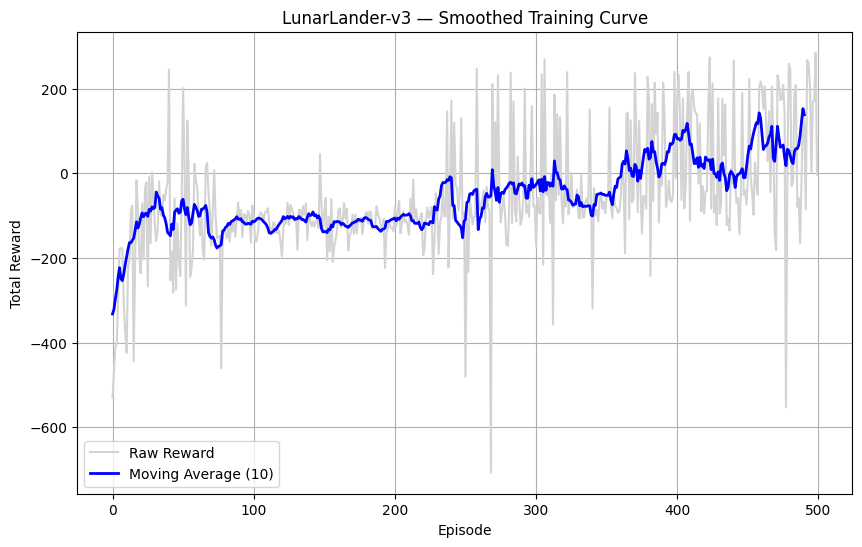

In [7]:
import matplotlib.pyplot as plt

def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10,6))
plt.plot(rewards, color='lightgray', label='Raw Reward')
plt.plot(moving_average(rewards, 10), color='blue', linewidth=2, label='Moving Average (10)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('LunarLander-v3 — Smoothed Training Curve')
plt.legend()
plt.grid(True)
plt.show()